In [65]:
!nvidia-smi

Tue Oct 29 19:12:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              32W /  70W |    107MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [66]:
import numpy as np
import math
import time
import cv2

# Загрузка изображения и преобразование в оттенки серого
image_path = 'input_0.bmp'
input_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Проверка успешности загрузки
if input_image is None:
    raise ValueError("Изображение не загружено. Проверьте путь.")
else:
   print("Изображение загружено успешно.")

Изображение загружено успешно.


In [67]:
from numba import cuda
import numba

# Ядро CUDA для медианного фильтра
@cuda.jit
def median_filter_kernel(input_image, output_image):
    i, j = cuda.grid(2)

    if 0 < i < input_image.shape[0] - 1 and 0 < j < input_image.shape[1] - 1:
        local_window = cuda.local.array(shape=9, dtype=numba.int64)
        idx = 0
        for di in range(-1, 2):
            for dj in range(-1, 2):
                local_window[idx] = input_image[i + di, j + dj]
                idx += 1

        for k in range(8):
            for l in range(8 - k):
                if local_window[l] > local_window[l + 1]:
                    local_window[l], local_window[l + 1] = local_window[l + 1], local_window[l]

        output_image[i, j] = local_window[4]

In [68]:
# Функция для применения медианного фильтра с помощью CUDA
def median_filter_gpu(host_input_image):
    block_size = (32, 32)
    grid_size = (math.ceil(host_input_image.shape[0] / block_size[0]),
                 math.ceil(host_input_image.shape[1] / block_size[1]))

    gpu_start_time = time.time()

    device_input_image = cuda.to_device(host_input_image)
    device_output_image = cuda.device_array(host_input_image.shape, dtype=host_input_image.dtype)

    median_filter_kernel[grid_size, block_size](device_input_image, device_output_image)

    output_image = device_output_image.copy_to_host()

    gpu_end_time = time.time()

    return output_image, gpu_end_time - gpu_start_time

In [69]:
# Функция для медианного фильтра на CPU
def median_filter_cpu(input_image):
    output_image = np.zeros_like(input_image)
    rows, cols = input_image.shape

    cpu_start_time = time.time()

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            local_window = input_image[i-1:i+2, j-1:j+2].flatten()
            output_image[i, j] = np.median(local_window)

    cpu_end_time = time.time()

    return output_image, cpu_end_time - cpu_start_time

In [71]:
# Применение медианного фильтра на GPU
filtered_image_gpu, time_gpu = median_filter_gpu(input_image)
print(f"Время выполнения на GPU: {time_gpu:.4f} сек")

# Применение медианного фильтра на CPU
filtered_image_cpu, time_cpu = median_filter_cpu(input_image)
print(f"Время выполнения на СPU: {time_cpu:.4f} сек")

print(f"Ускорение: {time_cpu/time_gpu:.4f}")

Время выполнения на GPU: 0.0027 сек
Время выполнения на СPU: 4.0996 сек
Ускорение: 1523.9536


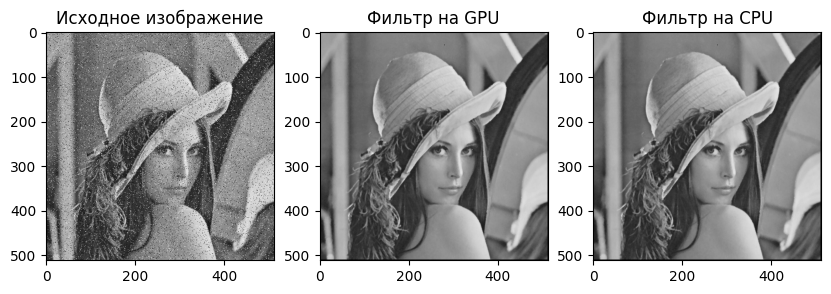

In [72]:
import matplotlib.pyplot as plt

# Визуализация результатов
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Исходное изображение")
plt.imshow(input_image, cmap='gray')
plt.subplot(1, 3, 2)
plt.title("Фильтр на GPU")
plt.imshow(filtered_image_gpu, cmap='gray')
plt.subplot(1, 3, 3)
plt.title("Фильтр на CPU")
plt.imshow(filtered_image_cpu, cmap='gray')
plt.show()

In [73]:
# Сохранение результатов в файлы
cv2.imwrite('filtered_image_gpu.bmp', filtered_image_gpu)
cv2.imwrite('filtered_image_cpu.bmp', filtered_image_cpu)

True

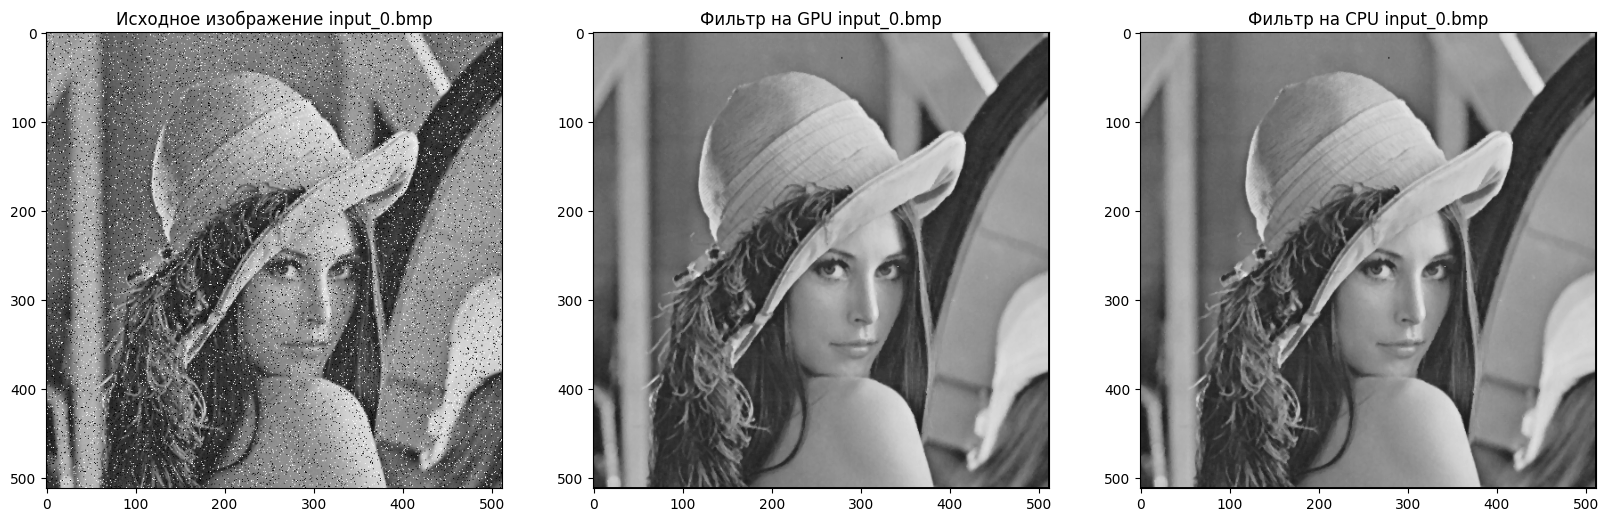

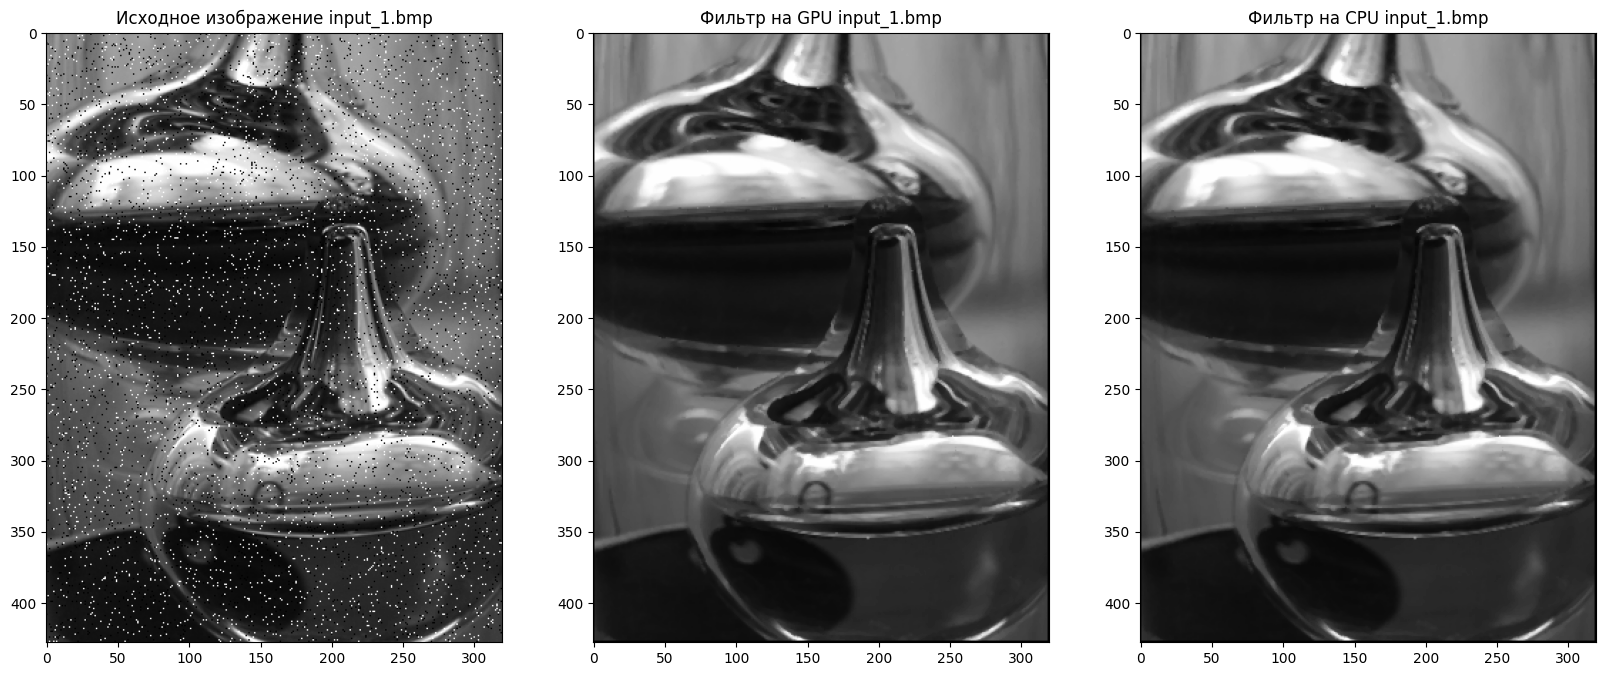

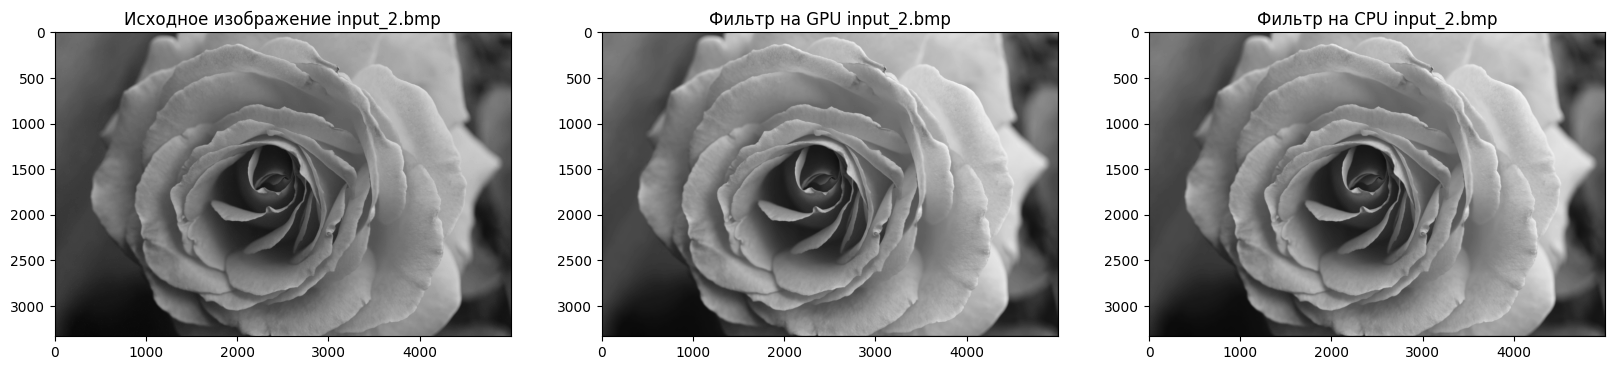

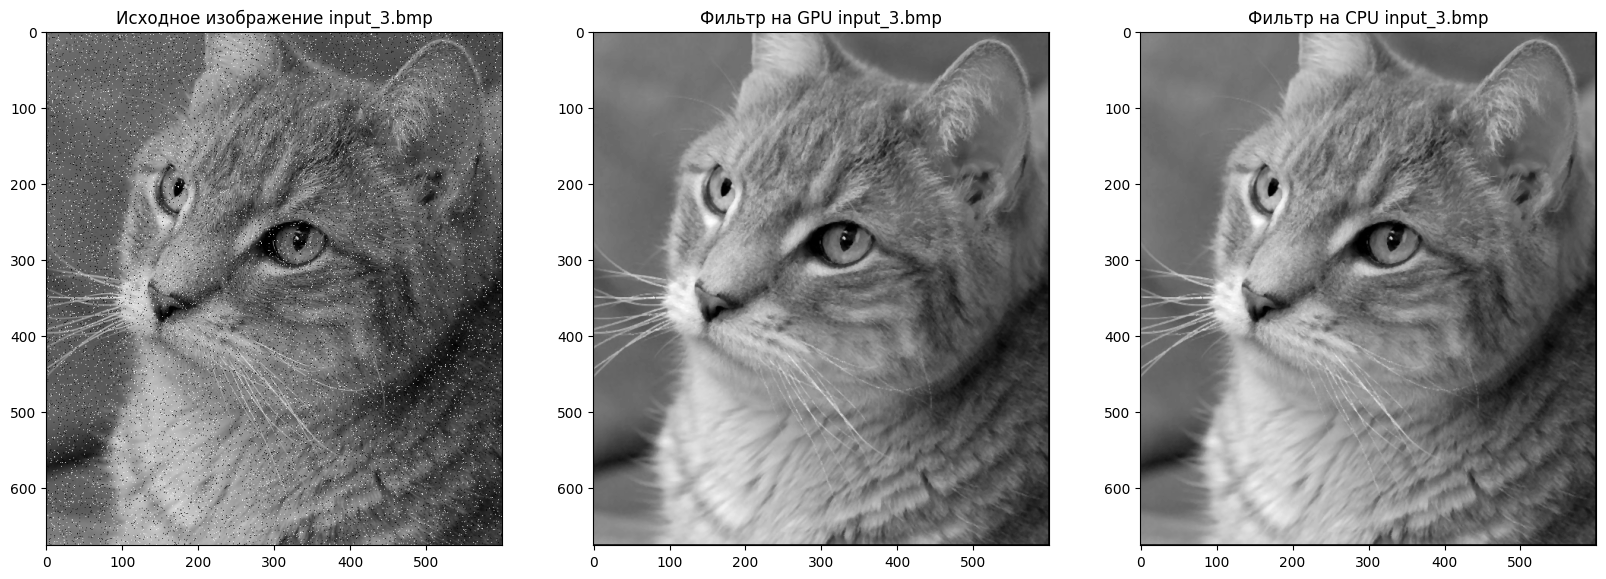

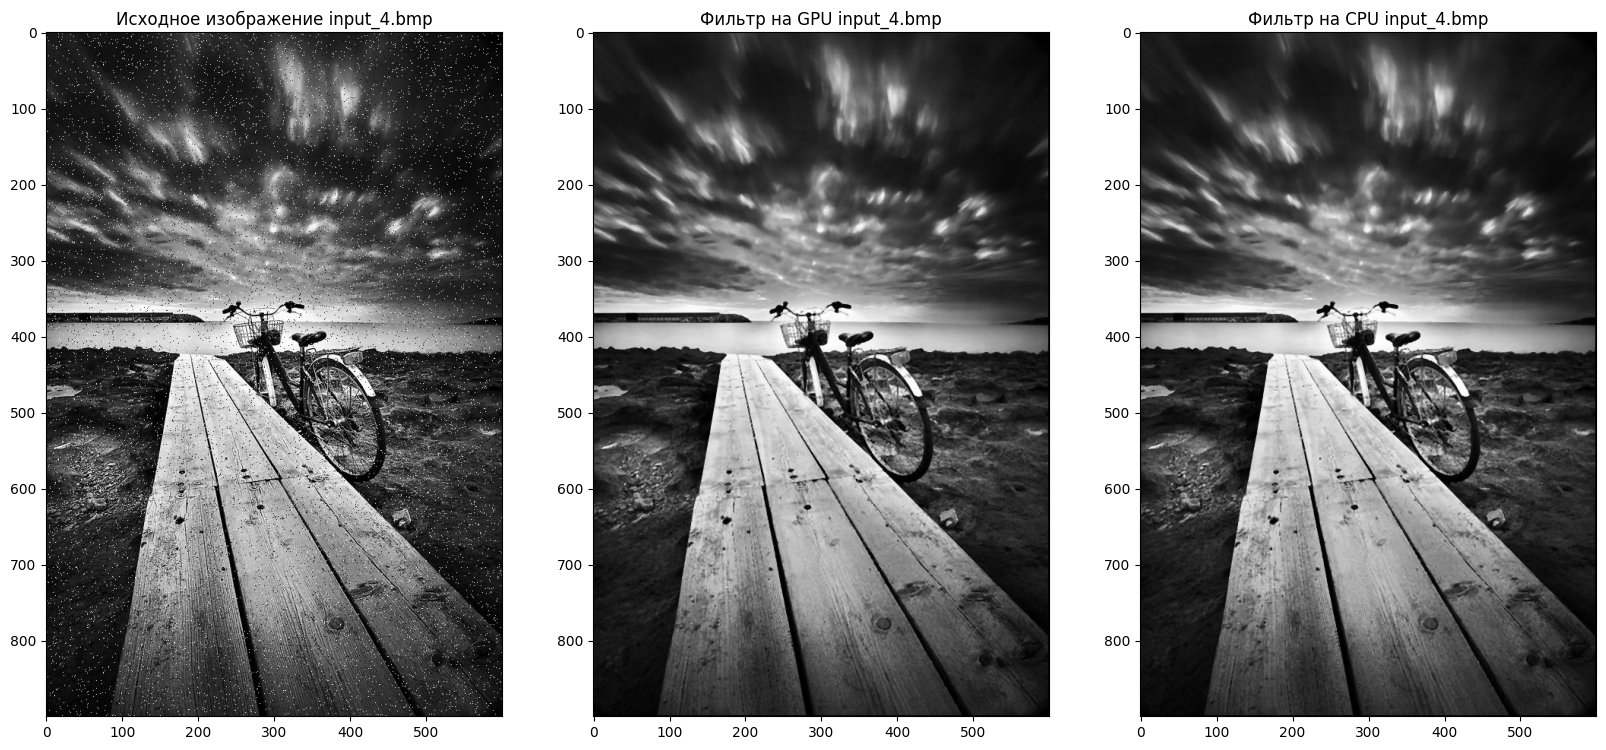

In [76]:
# Проверка для 5 изображений
image_paths = [f'input_{i}.bmp' for i in range(5)]

total_time_gpu = 0
total_time_cpu = 0
total_acceleration = 0

for idx, image_path in enumerate(image_paths):
    input_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if input_image is None:
        raise ValueError(f"Изображение {image_path} не загружено. Проверьте путь.")

    filtered_image_gpu, time_gpu = median_filter_gpu(input_image)
    total_time_gpu += time_gpu

    filtered_image_cpu, time_cpu = median_filter_cpu(input_image)
    total_time_cpu += time_cpu

    acceleration = time_cpu / time_gpu
    total_acceleration += acceleration

    # Визуализация результатов
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 3, 1)
    plt.title(f"Исходное изображение {image_path}")
    plt.imshow(input_image, cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title(f"Фильтр на GPU {image_path}")
    plt.imshow(filtered_image_gpu, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title(f"Фильтр на CPU {image_path}")
    plt.imshow(filtered_image_cpu, cmap='gray')
    plt.show()

In [77]:
# Вычисление среднего времени выполнения и ускорения
print(f"Среднее время выполнения на GPU: {total_time_gpu / len(image_paths):.4f} сек")
print(f"Среднее время выполнения на CPU: {total_time_cpu / len(image_paths):.4f} сек")
print(f"Среднее ускорение: {total_acceleration / len(image_paths):.4f}")

Среднее время выполнения на GPU: 0.0043 сек
Среднее время выполнения на CPU: 58.2747 сек
Среднее ускорение: 6257.2737
